In [8]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool
sys.path.append('..')
import loaders
import data
from extern.quarterTools import data_scaler

import warnings
from lightkurve import LightkurveWarning
warnings.filterwarnings("ignore", category=LightkurveWarning)



SEED = 12345
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
### Uncomment to mount the drive and/or bucket

# #lcs stored on drive for quick access
# data.mount_drive('/mnt/disks/lcs/')

# #other data products stored on google bucket
# !gcsfuse --implicit-dirs tess-goddard-lcs /home/jupyter/mountpoint

# Features

In [10]:
from extern import features

In [50]:
def get_subset(s):
    """Returns the subset features used to rescore a sector.
    
    Note: only Sector 18 has been rescored and had the reference subset
    saved as of 7/7/2023. 
    """
    try:
        df = feats  # if feats is defined in an earlier block
    except:
        datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
        df = pd.read_hdf(datafile, f"S{s}/features")

    subset_tics = np.loadtxt(f"/home/jupyter/mountpoint/dataproducts/s{s}_score_reference.txt")
    sample_subset = df.loc[subset_tics]
    return sample_subset

from sklearn import preprocessing

def data_scaler(data_to_scale, s=18):
    """Scales given features by the same factors as the given sector.
    
    This method recalculates the factors needed to scale each feature for a
    given sector. The features are scaled and shifted such that each set of
    features has a mean of zero and a standard deviation of one for
    the features calculated for all light curves in the given sector.
    
    Though possible, newly scaled data should not be expected to have a mean
    of zero or a standard a deviation of one for any feature.
    """
    try:
        df = feats.iloc[:, 0:61]
    except: 
        datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
        df = pd.read_hdf(datafile, f"S{s}/features")[:, 0:61]  # including mstat but not astat

    scaler = preprocessing.StandardScaler().fit(df)
    scaled = scaler.transform(data_to_scale)
    scaled = pd.DataFrame(index=data_to_scale.index,
                                columns=df.columns,
                                data=scaled)
    return scaled

def score_scaler(score):
    """Rescales "raw" scores to match Sector 18 rescored
    
    Calculated based on reference points. Not perfect, but pretty good
    Note: can't do similar to data_scaler because "raw" scores aren't saved
    """
    factor = 0.00018255470902209855
    offset = -4.34047914797675e-12
    scaled = score*factor+offset
    return scaled

def dist_scores(ref_data, d2s=None, k=1, scaler=False):
    """
    This method calculates the distance to the k-th neighbor in the reference data
    Args:
        ref_data (Numpy array or Pandas dataframe) - The reference data to which
            distances will be calculated
        d2s (Numpy array or Pandas dataframe) - Data to be scored (if None,
            same as the reference data)
        k (integer) - neighbor to calculate the distance

    Returns:
        scores (Numpy array) - distances for data in d2s.
    """


    if isinstance(d2s, type(None)):
        # if d2s is a dataframe, the evaluation of d2s==None tries to compare
        # every value of the dataframe to None, instead we check if it's
        # NoneType
        d2s = ref_data  # will default to full data if d2s is not specified

    if isinstance(scaler, type(data_scaler)):
        ref_data = scaler(ref_data)
        d2s = scaler(d2s)
    nbrs = NearestNeighbors(
        n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1).fit(ref_data)
    distances, indices = nbrs.kneighbors(d2s)

    scores = score_scaler(distances[:, k])

    return scores

        Flux1     Flux2     Flux3     Flux4     Flux5     Flux6     Flux7  \
0    1.012746  1.012746  1.012746  1.012746  1.012746  1.012746  1.012746   
1    1.011068  1.011068  1.011068  1.011068  1.011068  1.011068  1.011068   
2    1.013019  1.013019  1.013019  1.013019  1.013019  1.013019  1.013019   
3    1.012968  1.012968  1.012968  1.012968  1.012968  1.012968  1.012968   
4    1.010584  1.010584  1.010584  1.010584  1.010584  1.010584  1.010584   
..        ...       ...       ...       ...       ...       ...       ...   
879  1.000188  1.000188  1.000188  1.000188  1.000188  1.000188  1.000188   
880  0.998662  0.998662  0.998662  0.998662  0.998662  0.998662  0.998662   
881  0.998772  0.998772  0.998772  0.998772  0.998772  0.998772  0.998772   
882  0.995496  0.995496  0.995496  0.995496  0.995496  0.995496  0.995496   
883  1.005002  1.005002  1.005002  1.005002  1.005002  1.005002  1.005002   

        Flux8     Flux9    Flux10    Flux11    Flux12       Time    Depths 

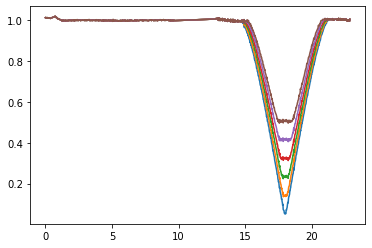

In [56]:
shape = "Circle"
fluxes = pd.read_csv("subplot_data/"+shape+ "_depth.csv")
for num in range(1,7):
    plt.plot(fluxes['Time'].values,fluxes["Flux%s" %(num)].values)
print(fluxes)


# Begin Refactor

In [111]:
"""Dan Comment
Put all your global variables up at the top, everything that only
needs to be defined once
"""
feats = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/db.v2.h5", "S18/features")
sector_scores = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/s18rescore.h5", "S18/scores")
sample_subset = get_subset(18).iloc[:,:61]

def get_shape_fluxes(shape, prefix="subplot_data_tic251630511/", suffix="_depth_spike.csv"):
    fluxes = pd.read_csv(prefix+shape+suffix)
    return fluxes

def get_test_features(shape):
    """Dan Comment:
    This function will import the injected light curves and get the features
    for them.

    These features won't change even if the scaling later does, this is a time
    consuming function so you want to redo it as little as possible, only the
    once if you can. I'd recommend just saving the features as variables for
    the notebook.
    """
    to_score_total = pd.DataFrame()

    fluxes = get_shape_fluxes(shape)
    test_time = fluxes["Time"].values

    for num in range(1,100):
        # Dan: changed the range since there are different numbers of columns
        try:
            test_flux = fluxes["Flux%s" %(num)].values
            test_err = np.zeros_like(test_flux, dtype='uint8')
        except:
            # Dan: this will stop the loop once it hits an unrecognized column
            break
        test_features = features.feats(test_time, test_flux, test_err)

        test_features = pd.DataFrame(columns=test_features.keys(), data=[test_features.values()])

        mstat = features.calc_mstat(test_flux)

        test_features['mstat'] = mstat
        test_feats = test_features

        to_score_total = to_score_total.append(test_feats)
    
    return to_score_total

feats_dict = {"Circle":get_test_features('Circle'), 
              "Square":get_test_features('Square'), 
              "Triangle":get_test_features('Triangle')}

In [112]:
"""Dan Comment
There's way too much output to do all three shapes at the same time.
Split it up so it's legible.

Since it was a loop, might as well make it a function

and I prefer to separate functionality from plotting,
plotting can be slow and functions can need to be changed often
"""
def function(shape):
    """Dan Comment
    I removed the placeholder arrays, opting instead to define things more
    directly in the lines they get calculated in
    """
    to_score = feats_dict[shape]

    # Do the scoring all at once
    # Got rid of the plotting here, can plot later
    scores = dist_scores(sample_subset, to_score, k=1, scaler=data_scaler)
    scores_df = pd.DataFrame(data=scores.T, columns=["scores"])
    
    # instead of a for loop around everything, I only implement a couple
    # in making specific lists
    shape_score = [sector_scores[sector_scores.scores>scores[i]]['rank'].max()+1
                   for i in range(len(to_score))]
    scores_df['ranks'] = shape_score 
    fluxes = get_shape_fluxes(shape)
    scores_df['min_flux'] = [min(fluxes["Flux%s" %(i+1)].values[:-200])
                          for i in range(len(to_score))]
    
    # I opt to organize things in dataframes because it keeps related information
    # tied together
    return scores_df

In [113]:
function("Circle")

,scores,ranks,min_flux
0,0.002589,3734.0,0.049074
1,0.002513,4034.0,0.136413
2,0.002195,5985.0,0.229986
3,0.002071,7153.0,0.319902
4,0.001975,8267.0,0.412433
5,0.001916,9047.0,0.503116
6,0.001835,10225.0,0.596440
7,0.001813,10546.0,0.686272
8,0.001727,11995.0,0.778925
9,0.001691,12687.0,0.871119


In [114]:
circle_scores = function("Circle")
triangle_scores = function("Triangle")
square_scores = function("Square")
print(circle_scores, triangle_scores, square_scores)

      scores    ranks  min_flux
0   0.002589   3734.0  0.049074
1   0.002513   4034.0  0.136413
2   0.002195   5985.0  0.229986
3   0.002071   7153.0  0.319902
4   0.001975   8267.0  0.412433
5   0.001916   9047.0  0.503116
6   0.001835  10225.0  0.596440
7   0.001813  10546.0  0.686272
8   0.001727  11995.0  0.778925
9   0.001691  12687.0  0.871119
10  0.001246  29742.0  0.964349
11  0.000898  89404.0  0.974750      scores    ranks  min_flux
0  0.001918   9031.0  0.559132
1  0.001946   8618.0  0.628771
2  0.001807  10657.0  0.714090
3  0.001690  12710.0  0.815738
4  0.001578  15185.0  0.918253
5  0.000899  88889.0  0.974750       scores    ranks  min_flux
0   0.002714   3342.0  0.014785
1   0.002657   3521.0  0.049887
2   0.002479   4197.0  0.112183
3   0.002253   5518.0  0.182685
4   0.002130   6546.0  0.274071
5   0.002067   7198.0  0.380873
6   0.001961   8439.0  0.500272
7   0.001862   9796.0  0.608996
8   0.001733  11897.0  0.728203
9   0.001760  11399.0  0.844745
10  0.001320  2

In [107]:
circle_scores = function("Circle")
triangle_scores = function("Triangle")
square_scores = function("Square")
print(circle_scores, triangle_scores, square_scores)

     scores    ranks  min_flux
0  0.002460   4287.0  0.737413
1  0.002076   7099.0  0.738457
2  0.001891   9389.0  0.739260
3  0.001741  11731.0  0.739260
4  0.001695  12628.0  0.739260
5  0.001823  10395.0  0.739260      scores    ranks  min_flux
0  0.002465   4262.0  0.711619
1  0.002145   6413.0  0.711626
2  0.001876   9609.0  0.711634
3  0.001816  10509.0  0.711656
4  0.001717  12174.0  0.711703
5  0.001814  10544.0  0.711874      scores    ranks  min_flux
0  0.002509   4056.0  0.678511
1  0.002095   6909.0  0.679314
2  0.001887   9475.0  0.679314
3  0.001746  11649.0  0.679314
4  0.001709  12317.0  0.679314
5  0.001835  10225.0  0.679314


In [108]:
circle_scores = function("Circle")
triangle_scores = function("Triangle")
square_scores = function("Square")
print(circle_scores, triangle_scores, square_scores)

     scores    ranks  min_flux
0  0.002460   4287.0  0.737413
1  0.002076   7099.0  0.738457
2  0.001891   9389.0  0.739260
3  0.001741  11731.0  0.739260
4  0.001695  12628.0  0.739260
5  0.001823  10395.0  0.739260      scores    ranks  min_flux
0  0.002465   4262.0  0.711619
1  0.002145   6413.0  0.711626
2  0.001876   9609.0  0.711634
3  0.001816  10509.0  0.711656
4  0.001717  12174.0  0.711703
5  0.001814  10544.0  0.711874      scores    ranks  min_flux
0  0.002509   4056.0  0.678511
1  0.002095   6909.0  0.679314
2  0.001887   9475.0  0.679314
3  0.001746  11649.0  0.679314
4  0.001709  12317.0  0.679314
5  0.001835  10225.0  0.679314


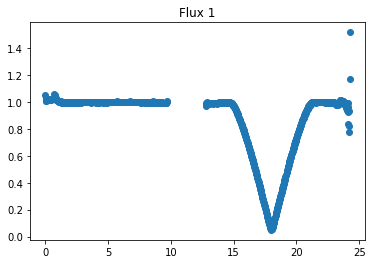

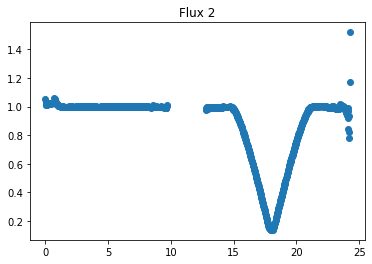

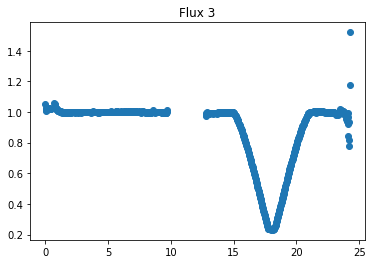

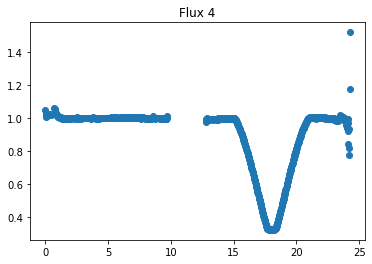

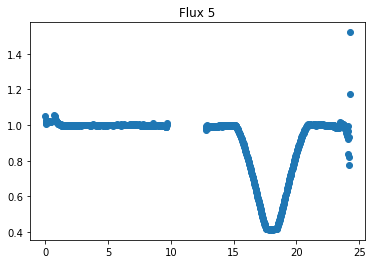

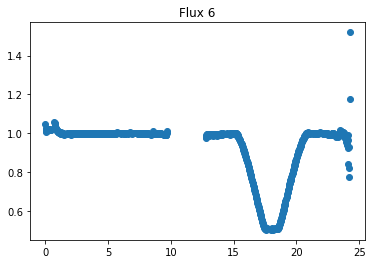

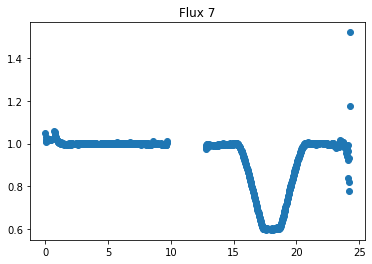

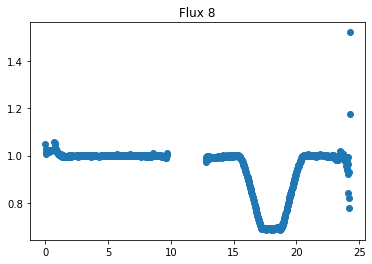

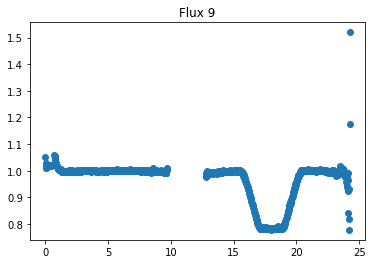

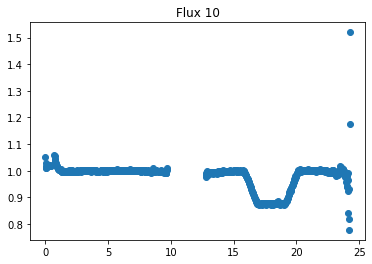

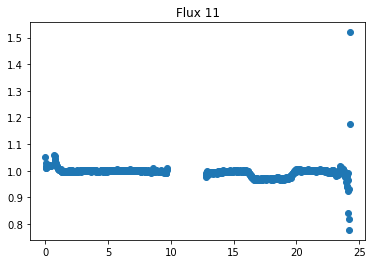

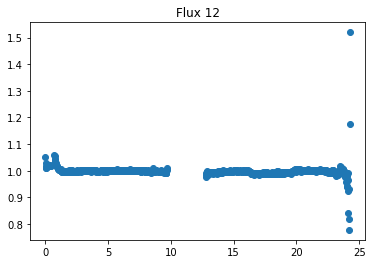

In [65]:
#plotting
fluxes = get_shape_fluxes("Circle")
for num in range(1, 13):
    plt.scatter(fluxes["Time"], fluxes[f"Flux{num}"])
    plt.title(f"Flux {num}")
    plt.show()
    plt.close()

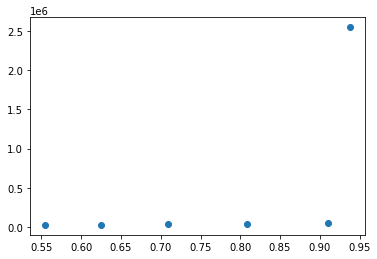

In [38]:
#plot rankings
plt.scatter(triangle_scores['min_flux'], triangle_scores['ranks'])

# End Dan Edits (for now)

In [106]:
#width csvs
shape = 'Circle'
circle_scores.to_csv('./subplot_data_tic251630511/rankings_width_' + shape +'.csv', index=True)

In [117]:
#depth csvs
shape = 'Square'
square_scores.to_csv('./subplot_data_tic251630511/rankings_depth_' + shape +'.csv', index=True)

In [ ]:
shape_depths = 1-shape_depths
plt.title(shape)
plt.xlabel("Transit Depth")
plt.ylabel("Ranking")
plt.scatter(shape_depths, shape_scores)
plt.show()

print(to_score_total)

to_score_total.to_csv('features.csv', index=True)

print(rank_scores)
#tri_scores=rank_scores

shape_scores = rank_scores#np.array([9., 9., 9., 9. 9. 6.])
shape_depths = np.array([])

for num in range(1,13):
    depth = min(fluxes["Flux%s" %(num)].values)
    shape_depths = np.append(shape_depths, depth)
    
shape_depths = 1-shape_depths
print(shape_depths)

plt.title(shape)
plt.xlabel("Transit Depth")
plt.ylabel("Ranking")
plt.scatter(shape_depths, shape_scores)
print(len(shape_depths), len(shape_scores))


In [ ]:
plt.scatter(sector_scores['rank'], sector_scores.scores)
plt.yscale('log')
plt.ylim(1E-4, 1E0)

# Appendix: Scaling distances -> scores

In [ ]:
scores_df["TIC_ID"] = sample_subset.index.astype(int)

In [ ]:
refpoints = sector_scores[sector_scores.TIC_ID.isin(scores_df.head(2).TIC_ID)].reset_index()

In [ ]:
scores_df.head(2)

In [ ]:
refpoints

In [ ]:
diff_abs = scores_df.head(2).loc[1, 'scores']-scores_df.head(2).loc[0, 'scores']

dif_scaled = refpoints.loc[1,'scores']-refpoints.loc[0,'scores']

factor = dif_scaled/diff_abs

offset = refpoints.loc[1,'scores']-factor*scores_df.head(2).loc[1, 'scores']

In [ ]:
print(f"score = {factor:.3E} * distance + {offset:.3E}")

In [ ]:
features = pd.read_csv("features.csv")
print(features[features.columns[1]])
outliers = (features.tail(2))


#fig = plt.figure(figsize=(25,30))
#ax = fig.gca()
features.hist()#(ax = ax)
outliers.hist()#(ax = ax)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
sample_subset=pd.read_csv("sample_subset.csv")
features = pd.read_csv("features.csv")
features=features.head(10)
outliers = features.tail(2)

#num_columns = features.shape[1]

num_rows = 6
num_cols = 11

fig, axs = plt.subplots(31, 2, figsize=(30,120))

axs = axs.flatten()

for i, column in enumerate(features.columns):
    axs[i].hist(sample_subset[column], bins=100, label = 'sector 18 sample')
    axs[i].hist(features[column], label = 'injected sample w/o outliers', bins=10, color = 'black')
    axs[i].hist(outliers[column], label='Outliers', color ='red', bins=3)
    axs[i].set_title(f"{column} Histogram")
    
        
    for injected_value in features[column]:
        axs[i].axvline(injected_value, color='black', linestyle='dashed')
    for outlier_value in outliers[column]:
        axs[i].axvline(outlier_value, color='red', linestyle='dashed')


plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
mstat_gt_1 = sample_subset[sample_subset['mstat'] > 1]
print(len(mstat_gt_1))
